# Projet IA - Modèle d'Ising 2D - 2023/2024
Sorbonne Université - Master 1 - Physique Fondamentale et Applications

Guilherme Carvalho - Anatole Cremel-Schlemer - Panet Mathis

## Introduction - Code necessaire

In [14]:
# Importation des librairies
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, Accuracy, AUC
from tensorflow.keras.utils import plot_model

# Dossier de travail
file_dir = "./data/"

In [2]:
# Importation des données fournis
def read_t(t,root="./", str_check=False):
  if not str_check :
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
  else :
    data = pickle.load(open(root+f'Ising2DFM_reSample_L40_T={t}.pkl','rb'))
  return np.unpackbits(data).astype(int).reshape(-1,1600)

data_all = read_t("All", file_dir, True)
data_label = pickle.load(open(file_dir+f'Ising2DFM_reSample_L40_T=All_labels.pkl','rb'))
print("Données importées")

Données importées


## Partie 1 : Génération de données

In [3]:
# Symétrisation des données (cf. Partie 2)

nom_temp = np.arange(0.25, 4.25, 0.25)

tot_data = np.empty((0,40,40))
tot_label = np.empty(0)

for T in nom_temp :
  tmp = read_t(T, file_dir)
  tot_data = np.concatenate((tot_data, tmp.reshape(tmp.shape[0], 40, 40)))
  tot_label = np.concatenate((tot_label, T*np.ones(tmp.shape[0])))

tot_data_sym = 2*np.abs(tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1) - 0.5)

In [4]:
# Importation des données générées

new_data = np.load("./new_data_accelerated.npy")

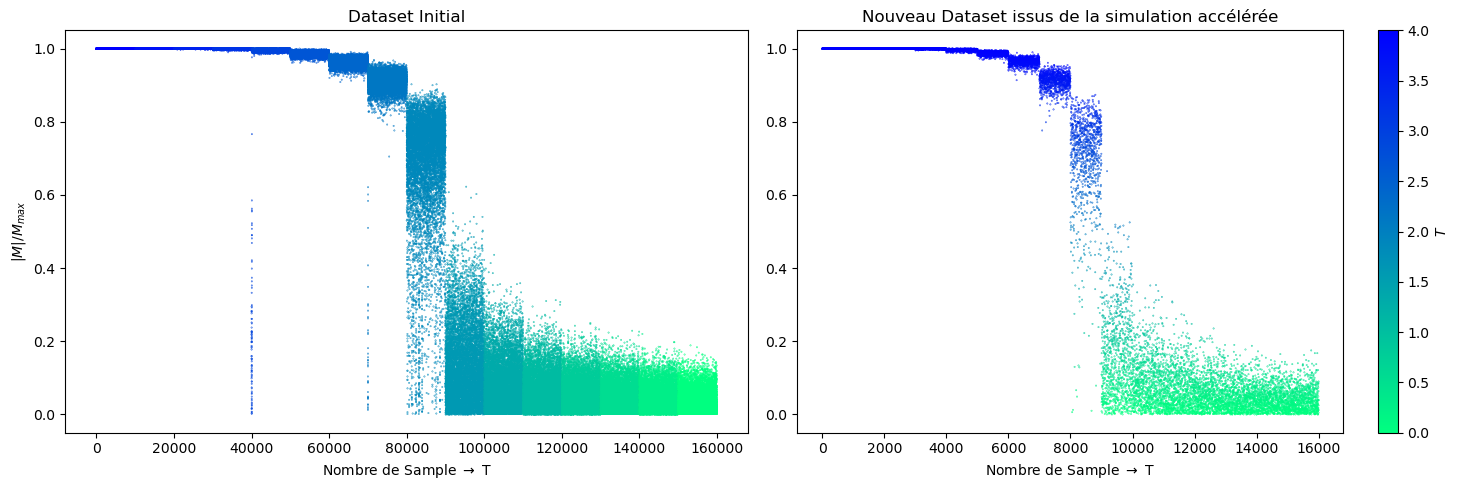

In [5]:
# Figure 1.6

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cmap = mpl.colormaps['winter']
axs[0].scatter(range(tot_data_sym.shape[0]), tot_data_sym, c=tot_label, cmap=cmap, s=0.1)
axs[0].set_ylabel(r'$|M|/M_{max}$')
axs[0].set_xlabel(r'Nombre de Sample $\rightarrow$ T')
axs[0].set_title(r'Dataset Initial')

cmap = mpl.colormaps['winter_r']
axs[1].scatter(range(new_data.shape[0]), new_data, c=new_data, cmap=cmap, s=0.1)
axs[1].set_xlabel(r'Nombre de Sample $\rightarrow$ T')
axs[1].set_title(r'Nouveau Dataset issus de la simulation accélérée')

plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4), cmap=cmap), ax=axs[1], label=r'$T$')
plt.tight_layout()
plt.show()

## Partie 2 : Pré-traitement des données

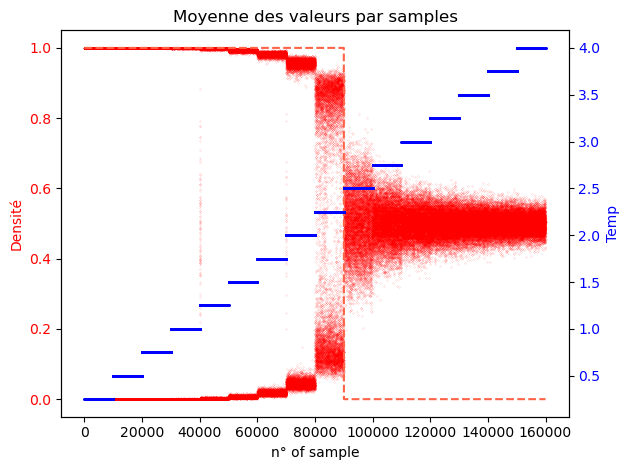

In [6]:
# Figure 2.1a
fig, ax1 = plt.subplots()

ax1.set_xlabel('n° of sample')
ax1.set_ylabel('Densité', color="red")
ax1.scatter(range(160000), tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1), s=.005, label="Mean value of samples", c="r")
ax1.plot(range(160000), data_label, "--", label="Labels", c='tomato')
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()

ax2.set_ylabel('Temp', color="b")
ax2.scatter(range(160000), tot_label, s=.1, label="Temps", c="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title("Moyenne des valeurs par samples")

fig.tight_layout()
plt.show()

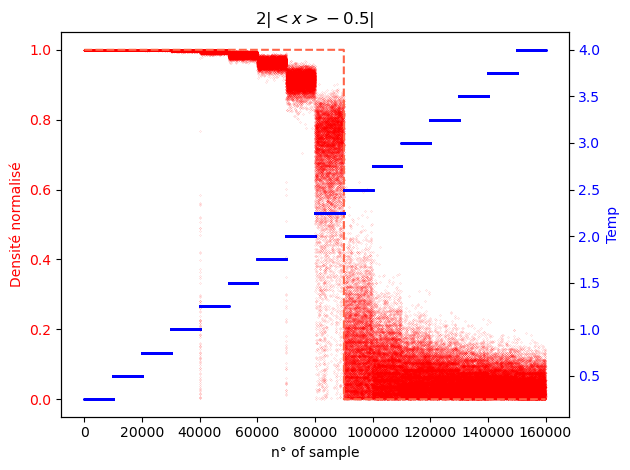

In [7]:
# Figure 2.1b
fig, ax1 = plt.subplots()

ax1.set_xlabel('n° of sample')
ax1.set_ylabel('Densité normalisé', color="red")
ax1.scatter(range(160000), tot_data_sym, s=.005, label="Mean value of samples", c="r")
ax1.plot(range(160000), data_label, "--", label="Labels", c='tomato')
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()

ax2.set_ylabel('Temp', color="b")
ax2.scatter(range(160000), tot_label, s=.1, label="Temps", c="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title(r'$2 |<x> - 0.5|$')

fig.tight_layout()
plt.show()

## Partie 3 : Modèles classiques

In [11]:
# Modèle de Forêt Aléatoire
T_C = 2.269

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(tot_data_sym.reshape(-1,1), tot_label, test_size=0.2, random_state=42)

# Créer le modèle de régression de forêt aléatoire
forest_model = RandomForestRegressor(max_depth=5, bootstrap=True, n_estimators=100)

# Adapter le modèle aux données d'entraînement
forest_model.fit(X_train, y_train)

# Prédire sur les données de test
predictions = forest_model.predict(X_test)

# Classe réelle
real_class = np.where(y_test>T_C, 1, 0)

# Classe prédite
pred_class = np.where(predictions>T_C, 1, 0)

# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)
print("mse:", mse)

kde_data = pd.DataFrame({'T':tot_label, 'Sym':tot_data_sym})
xnew = np.linspace(0, 1, 100)
ynew = forest_model.predict(xnew.reshape(-1, 1))

mse: 0.10820179984235787


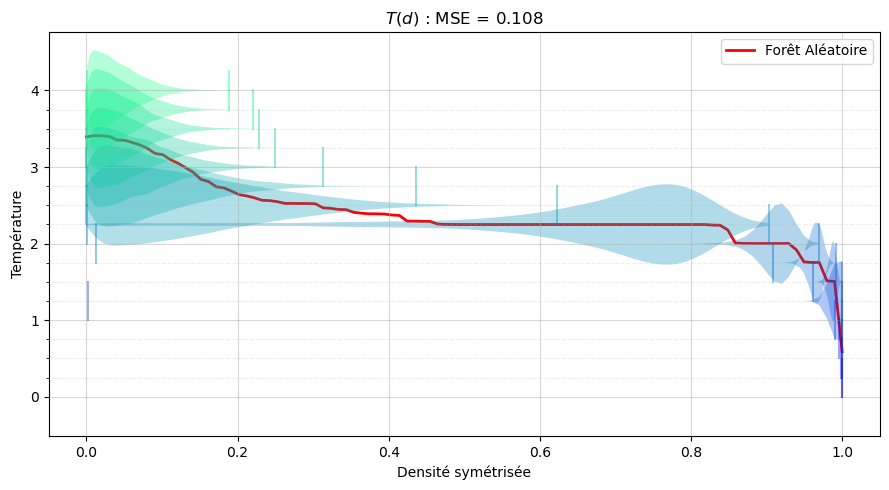

In [12]:
# Figure 3.1a
fig, ax = plt.subplots(figsize=(9, 5))
cmap = plt.get_cmap('winter', 16)

violinplots = []

for i in range(16):
    violinplot = ax.violinplot(
        kde_data[kde_data['T'] == nom_temp[i]]['Sym'],
        positions=[nom_temp[i]],
        showmeans=False,
        showextrema=True,
        widths=1.05,
        vert=False,
    )
    # Changer les couleurs en utilisant cmap
    violinplot['cmaxes'].set_color(cmap(i))
    violinplot['cmins'].set_color(cmap(i))
    violinplot['cbars'].set_color(cmap(i))
    for pc in violinplot['bodies']:
        pc.set_facecolor(cmap(i))
    # Changer l'épaisseur de ligne et l'opacité de la ligne
    violinplot['cmaxes'].set_alpha(0.4)
    violinplot['cmins'].set_alpha(0.4)
    violinplot['cbars'].set_alpha(0)
    
    violinplots.append(violinplot)

# Ajouter la ligne de la forêt aléatoire
ax.plot(xnew, ynew, color='r', linewidth=2, zorder=0, label="Forêt Aléatoire")

# Créer la légende
ax.legend()

# Ajouter des ticks mineurs à l'axe y
ax.set_yticks(nom_temp, minor=True)

ax.set_xlabel("Densité symétrisée")
ax.set_ylabel("Température")
ax.set_title(f"$T(d)$ : MSE = {mse:.3f}")

# Ajouter une grille aux ticks majeurs et mineurs
ax.grid(which='major', alpha=0.5, zorder=-1)
ax.grid(which='minor', alpha=0.2, linestyle='--', zorder=-1)

plt.tight_layout()
plt.show()

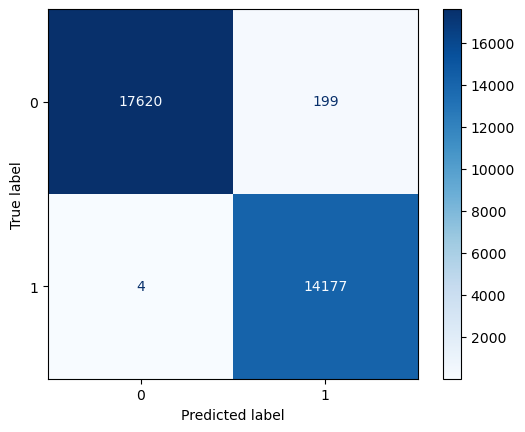

In [13]:
# Figure 3.1b
conf_mat = confusion_matrix(real_class, pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')
plt.show()

## Partie 4 : Réseaux de neurones

In [ ]:
# Creation des données pour le modèle de CNN
mean_val = tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1)
tot_data = tot_data.astype(np.uint8)

tot_data[mean_val > 0.5] = np.invert(tot_data[mean_val > 0.5])//255
tot_data.shape

In [ ]:
# Création du modèle de CNN
tot_data_cnn = tot_data.reshape(tot_data.shape[0], 40, 40, 1)

X_train, X_test, y_train, y_test = train_test_split(tot_data_cnn, data_label, test_size=0.2, random_state=42)

model = Sequential()
model.add(Conv2D(16, (5, 5), input_shape=(40, 40, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
model.summary()

In [ ]:
# Figure 4.1
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Entraînement du modèle de CNN
callback = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.2, callbacks = [callback])

In [ ]:
# Figure 4.2
plt.subplot(211)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Evolution')

plt.subplot(212)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Evolution')

plt.tight_layout()
plt.show()

In [ ]:
# Affichage des métriques
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test)
print('test loss', test_loss)
print('test accuracy', test_accuracy)
print('test precision', test_precision)
print('test recall', test_recall)
print('test auc', test_auc)

In [ ]:
# Figure 4.4
y_pred = model.predict(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Figure 4.5
y_pred.reshape(32000,)

y_pred_binary = (y_pred > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()

classes = ['Classe 0', 'Classe 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Prédit')
plt.ylabel('Réel')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.show()